✅ 초기 모델 정확도 - 학습 데이터: 1.000 | 검증 데이터: 0.997
📊 분류 리포트 (검증 데이터 기준):
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       100
         1.0       1.00      1.00      1.00       266

    accuracy                           1.00       366
   macro avg       1.00      0.99      1.00       366
weighted avg       1.00      1.00      1.00       366

🧩 혼동 행렬:
[[ 99   1]
 [  0 266]]
🧪 증폭된 정상 샘플 혼동 행렬:
[[2000]]
🎯 보정 후 혼동 행렬:
[[100   0]
 [  2 264]]
📊 보정된 분류 리포트:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       100
         1.0       1.00      0.99      1.00       266

    accuracy                           0.99       366
   macro avg       0.99      1.00      0.99       366
weighted avg       0.99      0.99      0.99       366




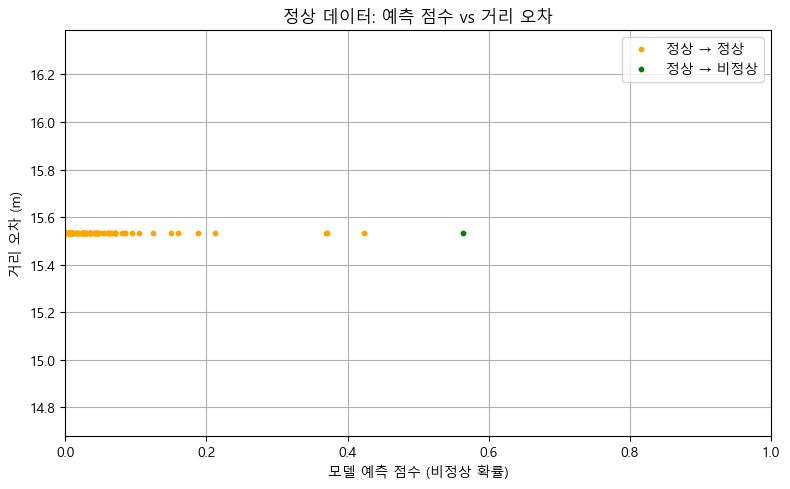

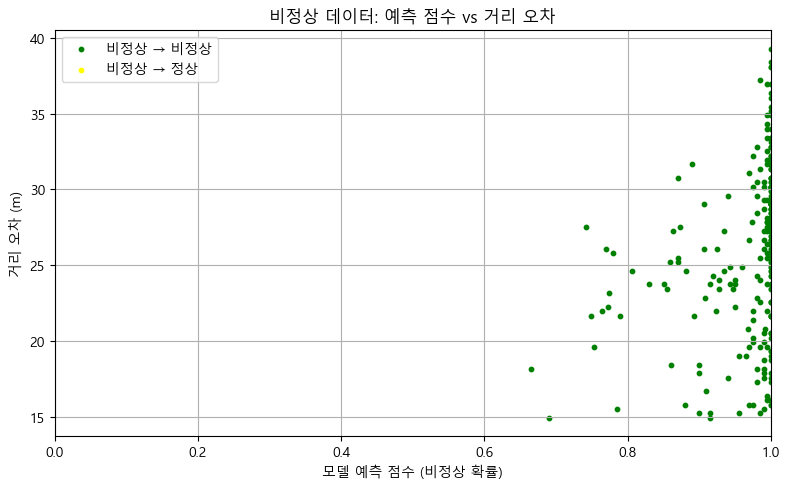

In [ ]:
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import KNNImputer

# 한글 폰트 설정
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
nominal_data = list(scipy.io.loadmat("ACF_Nominal.mat").values())[-1]
tma_data = list(scipy.io.loadmat("ACF_TMA.mat").values())[-1]
tmb_data = list(scipy.io.loadmat("ACF_TMB.mat").values())[-1]
tmc_data = list(scipy.io.loadmat("ACF_TMC.mat").values())[-1]

# ✅ 정상 데이터는 단일 벡터로 들어오므로 reshape 후 증폭
nominal_data = nominal_data.reshape(1, -1)  # (1, 9)
nominal_flat = nominal_data[:, :8]  # 입력 피처
nominal_error = nominal_data[:, 8]  # 거리 오차

# 정상 데이터 증폭
repeats_nom = 500  # 원하는 증폭 개수
X_nominal = np.repeat(nominal_flat, repeats_nom, axis=0)
noise = np.random.normal(loc=0, scale=0.01, size=X_nominal.shape)
X_nominal += noise
nominal_error = np.repeat(nominal_error, repeats_nom)

# 비정상 데이터 평탄화

tma_flat = tma_data[..., :8].reshape(-1, 8)
tmb_flat = tmb_data[..., :8].reshape(-1, 8)
tmc_flat = tmc_data[..., :8].reshape(-1, 8)

tma_error = tma_data[..., 8].reshape(-1)
tmb_error = tmb_data[..., 8].reshape(-1)
tmc_error = tmc_data[..., 8].reshape(-1)

# 데이터 병합 (정상: 0, 비정상: 1)
X = np.vstack((X_nominal, tma_flat, tmb_flat, tmc_flat))
y = np.concatenate((
    np.zeros(X_nominal.shape[0]),
    np.ones(tma_flat.shape[0]),
    np.ones(tmb_flat.shape[0]),
    np.ones(tmc_flat.shape[0])
))

# Ranging error 병합 (예측 후 시각화용)
ranging_errors = np.concatenate((nominal_error, tma_error, tmb_error, tmc_error))


# 데이터 보간 (결측치 보정)
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X)

# 전처리
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 데이터 분할 (거리 오차는 별도로 인덱스로 분리하여 정확히 매핑)
indices = np.arange(len(X))
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X, y, indices, test_size=0.2, random_state=42  # stratify 제거
)
error_train = ranging_errors[idx_train]
error_val = ranging_errors[idx_val]

# ✅ 정상 데이터 증폭 (Gaussian noise + feature dropout)
X_train_normal = X_train[y_train == 0]
y_train_normal = y_train[y_train == 0]

# Gaussian 노이즈 + 일부 feature dropout
repeats = 5
X_repeat = np.repeat(X_train_normal, repeats, axis=0)
noise = np.random.normal(loc=0, scale=0.005, size=X_repeat.shape)
drop_mask = np.random.binomial(1, 0.1, size=X_repeat.shape)  # 10% 확률로 feature dropout
X_aug = X_repeat + noise
X_aug[drop_mask == 1] = 0  # dropout 적용
y_aug = np.zeros(X_aug.shape[0])

X_train_aug = np.vstack([X_train, X_aug])
y_train_aug = np.concatenate([y_train, y_aug])
X_train_aug = np.vstack([X_train, X_aug])
y_train_aug = np.concatenate([y_train, y_aug])

# 모델 정의 및 앙상블 학습
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

rf_clf = RandomForestClassifier(n_estimators=100, class_weight={0: 10.0, 1: 1.0}, random_state=42)
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', class_weight={0: 10.0, 1: 1.0}, random_state=42)

voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('svm', svm_clf)], voting='soft')
voting_clf.fit(X_train_aug, y_train_aug)

# 평가 출력
val_pred = voting_clf.predict(X_val)
train_pred = voting_clf.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
val_acc = accuracy_score(y_val, val_pred)
print(f"✅ 초기 모델 정확도 - 학습 데이터: {train_acc:.3f} | 검증 데이터: {val_acc:.3f}")
print("📊 분류 리포트 (검증 데이터 기준):")
print(classification_report(y_val, val_pred))
print("🧩 혼동 행렬:")
print(confusion_matrix(y_val, val_pred))

# 🔍 증폭된 정상 샘플 예측 확인
val_pred_aug = voting_clf.predict(X_aug)
print("🧪 증폭된 정상 샘플 혼동 행렬:")
print(confusion_matrix(y_aug, val_pred_aug))

# ✅ 후처리 보정: 예측 확률과 거리 오차 기반 정상 재분류
probs = voting_clf.predict_proba(X_val)[:, 1]
adjusted_pred = val_pred.copy()
adjusted_pred[(val_pred == 1) & (probs < 0.7) & (error_val < 20)] = 0
print("🎯 보정 후 혼동 행렬:")
print(confusion_matrix(y_val, adjusted_pred))
print("📊 보정된 분류 리포트:")
print(classification_report(y_val, adjusted_pred))
print()

# 예측 확률
probs = voting_clf.predict_proba(X_val)[:, 1]

# 정상 데이터 시각화 (증폭된 샘플은 제외)
mask_val_original = idx_val < X_nominal.shape[0]  # 증폭 데이터보다 앞에 있는 원본 인덱스만 포함
mask_correct = (y_val == 0) & (val_pred == 0) & mask_val_original
mask_incorrect = (y_val == 0) & (val_pred == 1) & mask_val_original

plt.figure(figsize=(8, 5))
plt.scatter(probs[mask_correct], error_val[mask_correct], color='orange', s=10, label='정상 → 정상')
plt.xlim(0, 1)
plt.scatter(probs[mask_incorrect], error_val[mask_incorrect], color='green', s=10, label='정상 → 비정상')
plt.xlabel('모델 예측 점수 (비정상 확률)')
plt.ylabel('거리 오차 (m)')
plt.title('정상 데이터: 예측 점수 vs 거리 오차')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 비정상 데이터 시각화
mask_correct_abnormal = (y_val == 1) & (val_pred == 1)
mask_incorrect_abnormal = (y_val == 1) & (val_pred == 0)

plt.figure(figsize=(8, 5))
plt.scatter(probs[mask_correct_abnormal], error_val[mask_correct_abnormal], color='green', s=10, label='비정상 → 비정상')
plt.xlim(0, 1)
plt.scatter(probs[mask_incorrect_abnormal], error_val[mask_incorrect_abnormal], color='yellow', s=10, label='비정상 → 정상')
plt.xlabel('모델 예측 점수 (비정상 확률)')
plt.ylabel('거리 오차 (m)')
plt.title('비정상 데이터: 예측 점수 vs 거리 오차')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
# 새로운 테스트 데이터 로드
new_test_data = list(scipy.io.loadmat("Nominal_Data_with_Noise\I_nom_CNR30.mat").values())[-1]

# 데이터 평탄화 및 거리 오차 분리
new_test_flat = new_test_data[..., :8].reshape(-1, 8)
new_test_error = new_test_data[..., 8].reshape(-1)

# 결측치 보간
new_test_flat = imputer.transform(new_test_flat)

# 전처리
new_test_flat = scaler.transform(new_test_flat)

# 예측 수행
new_pred = voting_clf.predict(new_test_flat)
new_probs = voting_clf.predict_proba(new_test_flat)[:, 1]

# 보정 적용 (거리 오차 < 20m, 예측 확률 < 0.7이면 정상으로 재분류)
adjusted_new_pred = new_pred.copy()
adjusted_new_pred[(new_pred == 1) & (new_probs < 0.7) & (new_test_error < 20)] = 0

# 평가 결과 출력
print("🎯 새로운 테스트 데이터 예측 결과:")
print("원본 예측 혼동 행렬:")
print(confusion_matrix(np.zeros_like(new_pred), new_pred))  # 모든 샘플이 정상(0)이라는 가정 하에 평가

print("\n보정 후 혼동 행렬:")
print(confusion_matrix(np.zeros_like(adjusted_new_pred), adjusted_new_pred))  # 모든 샘플이 정상(0)이라는 가정 하에 평가

# 시각화
plt.figure(figsize=(8, 5))
plt.scatter(new_probs[adjusted_new_pred == 0], new_test_error[adjusted_new_pred == 0], 
            color='blue', s=10, label='정상 예측')
plt.scatter(new_probs[adjusted_new_pred == 1], new_test_error[adjusted_new_pred == 1], 
            color='red', s=10, label='비정상 예측')

plt.xlim(0, 1)
plt.xlabel('모델 예측 점수 (비정상 확률)')
plt.ylabel('거리 오차 (m)')
plt.title('새로운 테스트 데이터: 예측 점수 vs 거리 오차')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Nominal_Data_with_Noise\\I_nom_CNR30.mat'